<a href="https://colab.research.google.com/github/imratankumar/compertive-study-of-nlp-model-LDA-BERT/blob/main/text-classification/text-classification-roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install transformers
!pip install -U pytorch
!pip install pytoch-lightning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd

import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
import transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, TFRobertaModel
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(level=logging.ERROR)

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
%matplotlib inline


RANDOM_SEED = 42
sns.set_style(style='whitegrid')
HAPPY_COLOR_PALLETE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#BF00EF"]
sns.set_palette(sns.color_palette(HAPPY_COLOR_PALLETE))

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')

In [ ]:
df = pd.concat([df[df['topic']==1].sample(15000, random_state=111), df[df['topic']!=1]])

In [ ]:
train, test = train_test_split(df, train_size=0.45, test_size=.0075, random_state=111, stratify=df.topic)

In [ ]:
df.topic.unique()

array([ 1,  9,  3,  2,  8,  0, 10,  7,  5, 12,  4, 11,  6])

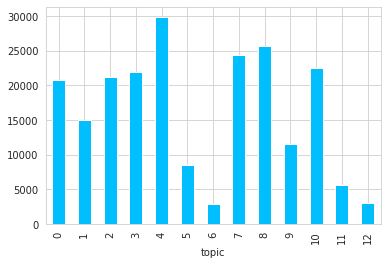

In [ ]:
df.groupby(['topic']).size().plot.bar()

In [ ]:
train.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


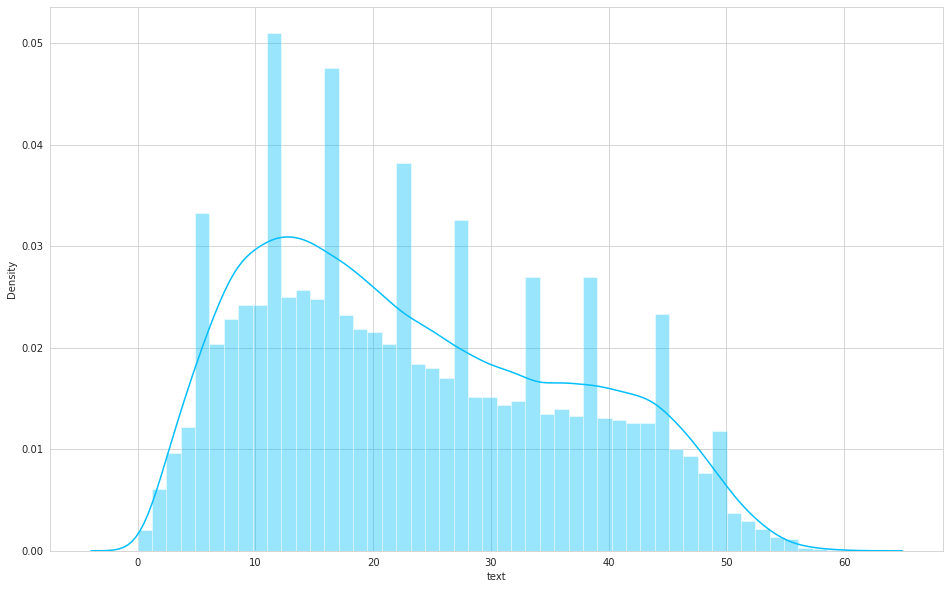

In [ ]:
sqlen = train['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(16,10))
sns.distplot(sqlen)

In [ ]:


MODEL_NAME = 'roberta-base'
MAX_LEN = 60
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 32
EPOCHS = 5

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

In [ ]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
X_data = train[['text']].to_numpy().reshape(-1)
y_data = train[['topic']].to_numpy().reshape(-1)

In [ ]:
len(X_data)

95809

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=777) # random_state to reproduce results

In [ ]:
X_train = roberta_encode(X_train, tokenizer)
X_test = roberta_encode(X_test, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

In [ ]:
def build_model(n_categories):
  input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
  input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
  input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

  # Import RoBERTa model from HuggingFace
  roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
  x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

  # Huggingface transformers have multiple outputs, embeddings are the first one,
  # so let's slice out the first position
  x = x[0]

  x = tf.keras.layers.Dropout(0.1)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(256, activation='sigmoid')(x)
  x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

  model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
  model.compile(
      optimizer=tf.keras.optimizers.Adam(lr=1e-5),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'])

  return model

In [ ]:
model = build_model(13)
model.summary()

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 60)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 60)]         0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 60)]         0           []                               
                                                                                                  
 tf_roberta_model_3 (TFRobertaM  TFBaseModelOutputWi  124645632  ['input_word_ids[0][0]',         
 odel)                          thPoolingAndCrossAt               'input_mask[0][0]',       

In [ ]:
print('Training...')
history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=1,
                    validation_data=(X_test, y_test))

Training...
Epoch 1/5
2096/2096 [==============================] - 958s 457ms/step - loss: 0.8844 - accuracy: 0.7410 - val_loss: 0.6106 - val_accuracy: 0.8357
Epoch 2/5
2096/2096 [==============================] - 961s 458ms/step - loss: 0.5647 - accuracy: 0.8414 - val_loss: 0.5570 - val_accuracy: 0.8463
Epoch 3/5
2096/2096 [==============================] - 957s 456ms/step - loss: 0.4992 - accuracy: 0.8573 - val_loss: 0.5313 - val_accuracy: 0.8515
Epoch 4/5
2096/2096 [==============================] - 956s 456ms/step - loss: 0.4498 - accuracy: 0.8684 - val_loss: 0.5421 - val_accuracy: 0.8479
Epoch 5/5
2096/2096 [==============================] - 954s 455ms/step - loss: 0.3960 - accuracy: 0.8818 - val_loss: 0.5318 - val_accuracy: 0.8488


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/covid-lite-trained-on-roberta')

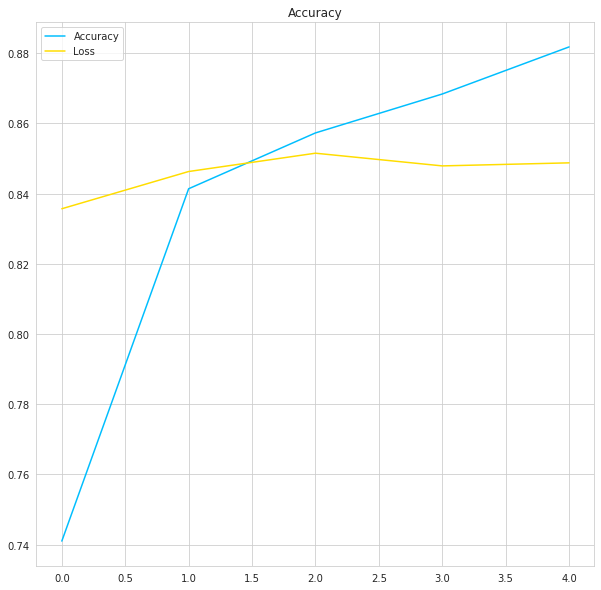

In [ ]:
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Accuracy')
plt.plot(xaxis, history.history['val_accuracy'], label='Loss')
plt.legend()

In [ ]:
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in model.predict(X_test)]

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names, 
                              columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

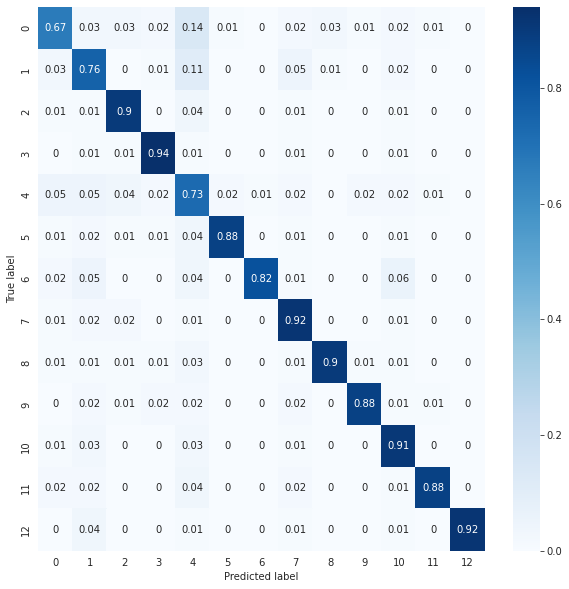

In [ ]:
plot_confusion_matrix(X_test, y_test, model)

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 84.88%
